In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
np.set_printoptions(suppress=True)

## Load all the Dataset Data

In [2]:
import os
import json

PRE_PROCESS_DATA_FOLDER = "pre_processed_data"

In [3]:
def infer_column_type(column:pd.Series):
    try:
        column = pd.to_numeric(column)
    except:
        print("Failed cast to a numeric type.")
    if column[0] == "False":
        
         False
    elif column[0] == "True":
        column = True
    column = column.astype(str)
    return column


In [4]:
data_list = []

for file in os.listdir(PRE_PROCESS_DATA_FOLDER):
    if ".json" not in file:
        continue
    with open(os.path.join(PRE_PROCESS_DATA_FOLDER, file), "r") as f:
        load_data = json.load(f)
    data_list.append(pd.Series(list(load_data.values()), index=load_data.keys()))

In [5]:
data = pd.DataFrame(data_list)

In [6]:
# Filters to apply:
approved_only = (data.approved_flag > 0).to_numpy() 
no_fixation_error = (data.fixation_error == False).to_numpy()
no_target_error = (data.target_error == False).to_numpy()
sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
acc_higher = (data.avg_roi_last_val > 0).to_numpy()
filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
filter_sets = np.array([True if set_lang in ["EN","ES","DE"] else False for set_lang in data["set_language"]])

screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720

mask = approved_only & no_fixation_error & no_target_error & sample_higher_10 & screen_above_1280_720 & acc_higher & filter_mturks & filter_sets

In [7]:
data_filtered = data[mask].copy()
print("Before: ", data.shape, " After: ", data_filtered.shape)

Before:  (341, 150)  After:  (194, 150)


In [8]:
data_filtered[data_filtered.set_language=="EN"].worker_lang.value_counts()

English       121
Indonesian      1
Marathi         1
Swahili         1
Name: worker_lang, dtype: int64

In [9]:
data_filtered[data_filtered.set_language=="DE"].worker_lang.value_counts()

German      14
English      4
Croatian     1
Name: worker_lang, dtype: int64

In [10]:
data_filtered[data_filtered.set_language=="ES"].worker_lang.value_counts()

Spanish               43
English                5
Ukrainian              1
Estonian               1
Chinese (Mandarin)     1
Name: worker_lang, dtype: int64

In [11]:
# Load the text settings:
text_settings_all_settings = pd.read_csv("text_token_stats.csv", index_col=0)

In [12]:
text_settings_all_settings[text_settings_all_settings.trial_name == data_filtered["trial_0_name"][0]]

,stimulus,trial_name,task_type,correct_answer,lang,set_name,char_count,token_count,token_avg_length,sentence_count,original_dataset,average_token_per_sentence,is_question
95,"In competitive sports, doping is the use of ba...",meco_para_3,NR,NaN,EN,mturk_EN_v01,1242,213,4.985915,9,MECO,23.666667,False


In [13]:
data_filtered["question_0_name"]

0       meco_para_3_qa_0
2      meco_para_11_qa_1
5      meco_para_12_qa_0
9       meco_para_3_qa_1
10     meco_para_12_qa_3
             ...        
326    meco_para_11_qa_2
327     meco_para_3_qa_0
328    meco_para_11_qa_1
329    meco_para_12_qa_1
331     meco_para_3_qa_0
Name: question_0_name, Length: 194, dtype: object

In [14]:
# Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
data_for_cls_nr = []
data_for_cls_is = []
rows_dropped = 0
for i in range(10):
    for row_i, row in data_filtered.iterrows():
        # Remove rows where there is no fixation on text
        if row[f"trial_{i}_fixation_text_TRT"] == 0:
            assert row[f"trial_{i}_fixation_target_TRT"] == 0
            rows_dropped += 1
            continue
        set_lang = row["set_language"] 
        set_name = row["set_name"]
        worker_id = row["worker_id"]
        trial_name = row[f"trial_{i}_name"]
        target = row[f"question_{i}_name"]
        
        text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                        & (text_settings_all_settings["trial_name"] == trial_name)]
        word_sent_avg = text_features_row["sentence_count"].item()
        participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
        in_span_TRT = []
        out_span_TRT = []
        for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
            if type(fix_row["Span_word_is_in"]) is str:
                if target in fix_row["Span_word_is_in"]:
                    in_span_TRT.append(fix_row["TRT"])
            else:
                out_span_TRT.append(fix_row["TRT"])
        in_span_mean = np.nanmean(np.array(in_span_TRT))
        if np.isnan(in_span_mean):
            in_span_mean = 0
        out_span_mean = np.nanmean(np.array(out_span_TRT))
        if np.isnan(out_span_mean):
            out_span_mean = 0
        data_to_append = row[[
                f"trial_{i}_fixation_text_TRT", 
                f"trial_{i}_fixation_target_TRT", 
                f"trial_{i}_fixation_on_target", 
                f"question_{i}_target_to_fixation_ratio",
                f"trial_{i}_fixation_total",
                #f"trial_{i}_time",
                f"question_{i}_correct_flag"]].to_numpy()
        relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
        data_to_append = np.hstack(( [
                                    in_span_mean,
                                    out_span_mean,
                                    relative_TRT,
                                    text_features_row["token_count"].item(),
                                    text_features_row["token_avg_length"].item(), 
                                      ], 
                                    data_to_append))
        # Trials < 5 are Normal Reading
        if i < 5:
            data_for_cls_nr.append(data_to_append)
        # Trials >= 5 are Information Seaking
        else:
            data_for_cls_is.append(data_to_append)
data_for_cls_nr = np.array(data_for_cls_nr)
data_for_cls_is = np.array(data_for_cls_is)

C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_4168\482827969.py:30: RuntimeWarning: 

In [15]:
rows_dropped, len(data_for_cls_is), len(data_for_cls_nr), len(data_for_cls_is)+len(data_for_cls_nr)

(18, 952, 970, 1922)

In [16]:
18/1940

0.009278350515463918

In [480]:
data_for_cls_is[:2]

array([[0.0, 461.72972972972974, 0.027389756231169543, 107.0,
        4.710280373831775, 43812.0, 1200.0, 11, 0.0306406685, 359, 0],
       [0.0, 176.77551020408163, 0.03033515452988665, 107.0,
        5.074766355140187, 12263.0, 372.0, 4, 0.0173913043, 230, 0]],
      dtype=object)

In [522]:
task_name = "nr"
if task_name == "nr":
    data_for_classifier = np.array(data_for_cls_nr,dtype=float)
else:
    data_for_classifier = np.array(data_for_cls_is,dtype=float)

In [523]:
all_data = np.vstack((data_for_cls_is,data_for_cls_nr))

In [524]:
print("Information Seeking")
len(data_for_cls_is[data_for_cls_is[:,-1] == 1]), len(data_for_cls_is[data_for_cls_is[:,-1] == 0])

Information Seeking


(766, 186)

In [525]:
data_for_cls_is[data_for_cls_is[:,-1] == 1][:,-2].mean()

111.31070496083551

In [526]:
data_for_cls_is[data_for_cls_is[:,-1] == 0][:,-2].mean()

136.29569892473117

In [527]:
print("Normal Reading")
len(data_for_cls_nr[data_for_cls_nr[:,-1] == 1]), len(data_for_cls_nr[data_for_cls_nr[:,-1] == 0])

Normal Reading


(537, 433)

In [528]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 1][:,-2].mean()

207.17877094972067

In [529]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 0][:,-2].mean()

188.3879907621247

In [530]:
data_for_classifier

array([[549.84615385, 567.71641791,   0.11231901, ...,   0.13079019,
        367.        ,   1.        ],
       [  0.        , 102.67741935,   0.        , ...,   0.01149425,
         87.        ,   1.        ],
       [399.        , 141.94      ,   0.04180199, ...,   0.04580153,
        131.        ,   1.        ],
       ...,
       [  0.        , 157.86666667,   0.        , ...,   0.        ,
         31.        ,   1.        ],
       [ 69.        , 236.39583333,   0.00300798, ...,   0.00333333,
        300.        ,   1.        ],
       [276.        , 259.82258065,   0.01187148, ...,   0.01395349,
        215.        ,   1.        ]])

In [531]:
data_for_classifier[0]

array([  549.84615385,   567.71641791,     0.11231901,   213.        ,
           4.98591549, 63747.        ,  7160.        ,    48.        ,
           0.13079019,   367.        ,     1.        ])

In [532]:
data_for_classifier[:,:-1]

array([[549.84615385, 567.71641791,   0.11231901, ...,  48.        ,
          0.13079019, 367.        ],
       [  0.        , 102.67741935,   0.        , ...,   1.        ,
          0.01149425,  87.        ],
       [399.        , 141.94      ,   0.04180199, ...,   6.        ,
          0.04580153, 131.        ],
       ...,
       [  0.        , 157.86666667,   0.        , ...,   0.        ,
          0.        ,  31.        ],
       [ 69.        , 236.39583333,   0.00300798, ...,   1.        ,
          0.00333333, 300.        ],
       [276.        , 259.82258065,   0.01187148, ...,   3.        ,
          0.01395349, 215.        ]])

In [533]:
X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

In [534]:
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, test_size=0.2)

In [535]:
def upscale_dataset(X_train, y_train):
    minority_label = y_train[0]
    count_min_label = (y_train == minority_label).sum()
    for label in np.unique(y_train):
        n_examples = (y_train == label).sum()
        if n_examples < count_min_label:
            minority_label = label

    unbalance_n = (y_train!=minority_label).sum()-(y_train==minority_label).sum()
    indexes_to_add = np.random.choice(X_train[y_train==minority_label].shape[0], size=unbalance_n, replace=True)
    new_X_train = np.vstack((X_train, X_train[indexes_to_add,:]))
    new_y_train = np.hstack((y_train,np.zeros(unbalance_n)))
    balanced_dataset = np.hstack([new_X_train,new_y_train.reshape(-1,1)])
    np.random.shuffle(balanced_dataset)

    return balanced_dataset[:,:-1], balanced_dataset[:,-1]

In [536]:
from imblearn.over_sampling import SMOTE

In [537]:
sm = SMOTE()

In [538]:
X_train, y_train = upscale_dataset(X_train_unb, y_train_unb)

In [539]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = make_pipeline(StandardScaler(), LogisticRegression())
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.58928571, 0.57738095, 0.58928571, 0.51497006, 0.53293413])

In [540]:
scores.mean()

0.5607713145138294

In [541]:
clf.fit(X_train, y_train)
print("Acc Score: ", accuracy_score(y_test_unb, clf.predict(X_test_unb)), 
                    "F1-Score", f1_score(y_test_unb, clf.predict(X_test_unb), average="weighted"))

Acc Score:  0.6030927835051546 F1-Score 0.6077986870533258


In [542]:
(y_test_unb==0).sum()

76

In [543]:
confusion_matrix(y_test_unb, clf.predict(X_test_unb))

array([[48, 28],
       [49, 69]], dtype=int64)

In [544]:
baseline = DummyClassifier()
baseline.fit(X_train_unb,y_train_unb)

DummyClassifier()

In [545]:
print("Acc Score: ", accuracy_score(y_test_unb, baseline.predict(X_test_unb)),
             "F1-Score", f1_score(y_test_unb, baseline.predict(X_test_unb)))

Acc Score:  0.6082474226804123 F1-Score 0.7564102564102563


In [546]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

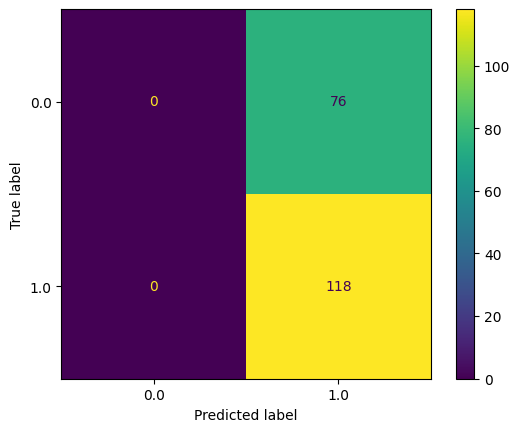

In [547]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb,baseline.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

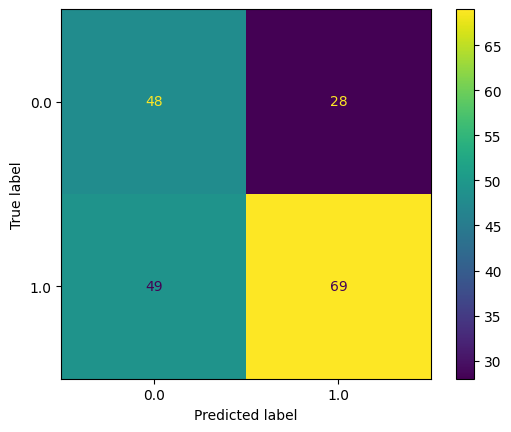

In [548]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb, clf.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

In [549]:
from sklearn.metrics import classification_report

In [550]:
print(classification_report(y_test_unb, clf.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.49      0.63      0.55        76
         1.0       0.71      0.58      0.64       118

    accuracy                           0.60       194
   macro avg       0.60      0.61      0.60       194
weighted avg       0.63      0.60      0.61       194



In [551]:
print(classification_report(y_test_unb, baseline.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        76
         1.0       0.61      1.00      0.76       118

    accuracy                           0.61       194
   macro avg       0.30      0.50      0.38       194
weighted avg       0.37      0.61      0.46       194



c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [552]:
classifier_dict = {
    "Baseline": DummyClassifier(strategy="uniform"),
    "Majority": DummyClassifier(strategy="prior"),
    "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
    "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
    "Random Forest": RandomForestClassifier(),
    #"MLPClassifier": MLPClassifier(),
}

In [559]:
classifier_results = {
    "Baseline": [],
    "Majority": [],
    "SVM": [],
    "Log.Reg": [],
    "Random Forest": [],
    #"MLPClassifier": [],

}

In [560]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
    for clf_name, clf in classifier_dict.items():
        if clf_name == "Majority":
            # Fit data to the original train data
            clf.fit(X_train, y_train)
        else:
            clf.fit(X_train_reb, y_train_reb)
        #print(f"## Results Clf: {clf_name}, seed = {i}")
        preds = clf.predict(X_test)
        acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
        f1_sco = f1_score(y_test, preds, average="weighted")
        f1_sco_macro = f1_score(y_test, preds, average="macro")
        #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
        classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))

In [561]:
print("Results for task: ", task_name.upper())
for clf_name, results in classifier_results.items():
    print(f"## Results for {clf_name} ##")
    results = np.array(results)
    print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
    print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
    print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
    print()

Results for task:  NR
## Results for Baseline ##
Acc: 0.4943 +/- 0.0394
F1-Score (Weighted): 0.4968 +/- 0.0381
F1-Score (Macro): 0.4914 +/- 0.0405

## Results for Majority ##
Acc: 0.5644 +/- 0.0299
F1-Score (Weighted): 0.4077 +/- 0.0358
F1-Score (Macro): 0.3606 +/- 0.0120

## Results for SVM ##
Acc: 0.5546 +/- 0.0230
F1-Score (Weighted): 0.5396 +/- 0.0232
F1-Score (Macro): 0.5462 +/- 0.0227

## Results for Log.Reg ##
Acc: 0.5510 +/- 0.0323
F1-Score (Weighted): 0.5441 +/- 0.0341
F1-Score (Macro): 0.5466 +/- 0.0335

## Results for Random Forest ##
Acc: 0.5918 +/- 0.0240
F1-Score (Weighted): 0.5931 +/- 0.0243
F1-Score (Macro): 0.5879 +/- 0.0236

